In [3]:
# Import necessary libraries
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from scipy.stats import pearsonr

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
# Load data from Excel files
energy_data = pd.read_excel("/content/drive/My Drive/energy.xlsx", sheet_name=["Motor fuel inflation", "Gas inflation"], skiprows=5)
food_data = pd.read_excel("/content/drive/My Drive/food.xlsx", sheet_name=["Food inflation", "Restaurant and cafe inflation"], skiprows=5)


In [13]:
energy_data['Motor fuel inflation']

,Date,Motor fuels
0,2012-10-01,2.4
1,2012-11-01,1.0
2,2012-12-01,-0.2
3,2013-01-01,-0.8
4,2013-02-01,0.8
...,...,...
131,2023-09-01,-9.7
132,2023-10-01,-7.6
133,2023-11-01,-10.6
134,2023-12-01,-10.8


In [15]:
energy_data['Gas inflation']

,Date,Gas
0,2012-10-01,-1.0
1,2012-11-01,-0.1
2,2012-12-01,5.2
3,2013-01-01,5.2
4,2013-02-01,7.2
...,...,...
131,2023-09-01,1.7
132,2023-10-01,-31.0
133,2023-11-01,-31.0
134,2023-12-01,-31.0


In [16]:
food_data['Food inflation']

,Date,Food and non-alcoholic beverages
0,2012-10-01,3.4
1,2012-11-01,3.9
2,2012-12-01,3.8
3,2013-01-01,4.2
4,2013-02-01,3.7
...,...,...
131,2023-09-01,12.2
132,2023-10-01,10.1
133,2023-11-01,9.2
134,2023-12-01,8.0


In [17]:
food_data["Restaurant and cafe inflation"]

,Date,Restaurants and cafés
0,2012-10-01,2.9
1,2012-11-01,3.0
2,2012-12-01,3.0
3,2013-01-01,2.9
4,2013-02-01,2.9
...,...,...
131,2023-09-01,9.1
132,2023-10-01,8.8
133,2023-11-01,8.2
134,2023-12-01,7.7


In [49]:
Motor_fuel_inflation = energy_data['Motor fuel inflation']
gas_inflation = energy_data['Gas inflation']
food_inflation = food_data['Food inflation']
restaurant_cafe_inflation = food_data['Restaurant and cafe inflation']

# Preprocess data

In [50]:
# Preprocess each dataframe to ensure date is set as index and in datetime format
def preprocess_sheet(df, column_name):
    # Strip whitespace from column names to avoid issues with extra spaces
    df.columns = df.columns.str.strip()

    # Check if 'Date' column exists and convert it to datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df.dropna(subset=['Date'], inplace=True)
        df.set_index('Date', inplace=True)

        # Ensure only the relevant inflation column is kept
        if column_name not in df.columns:
            raise KeyError(f"'{column_name}' column not found in the sheet.")
        df = df[[column_name]]
    else:
        raise KeyError(f"'Date' column not found in the sheet for {column_name}.")

    return df

# Apply preprocessing to each dataset
Motor_fuel_inflation = preprocess_sheet(Motor_fuel_inflation, 'Motor fuels')
gas_inflation = preprocess_sheet(gas_inflation, 'Gas')
food_inflation = preprocess_sheet(food_inflation, 'Food and non-alcoholic beverages')
restaurant_cafe_inflation = preprocess_sheet(restaurant_cafe_inflation, 'Restaurants and cafés')

# Verify preprocessing results by displaying the first few rows of each dataframe
print("Motor Fuel Inflation Data:\n", Motor_fuel_inflation.head())
print("\nGas Inflation Data:\n", gas_inflation.head())
print("\nFood Inflation Data:\n", food_inflation.head())
print("\nRestaurant and Cafe Inflation Data:\n", restaurant_cafe_inflation.head())

Motor Fuel Inflation Data:
             Motor fuels
Date                   
2012-10-01          2.4
2012-11-01          1.0
2012-12-01         -0.2
2013-01-01         -0.8
2013-02-01          0.8

Gas Inflation Data:
             Gas
Date           
2012-10-01 -1.0
2012-11-01 -0.1
2012-12-01  5.2
2013-01-01  5.2
2013-02-01  7.2

Food Inflation Data:
             Food and non-alcoholic beverages
Date                                        
2012-10-01                               3.4
2012-11-01                               3.9
2012-12-01                               3.8
2013-01-01                               4.2
2013-02-01                               3.7

Restaurant and Cafe Inflation Data:
             Restaurants and cafés
Date                             
2012-10-01                    2.9
2012-11-01                    3.0
2012-12-01                    3.0
2013-01-01                    2.9
2013-02-01                    2.9


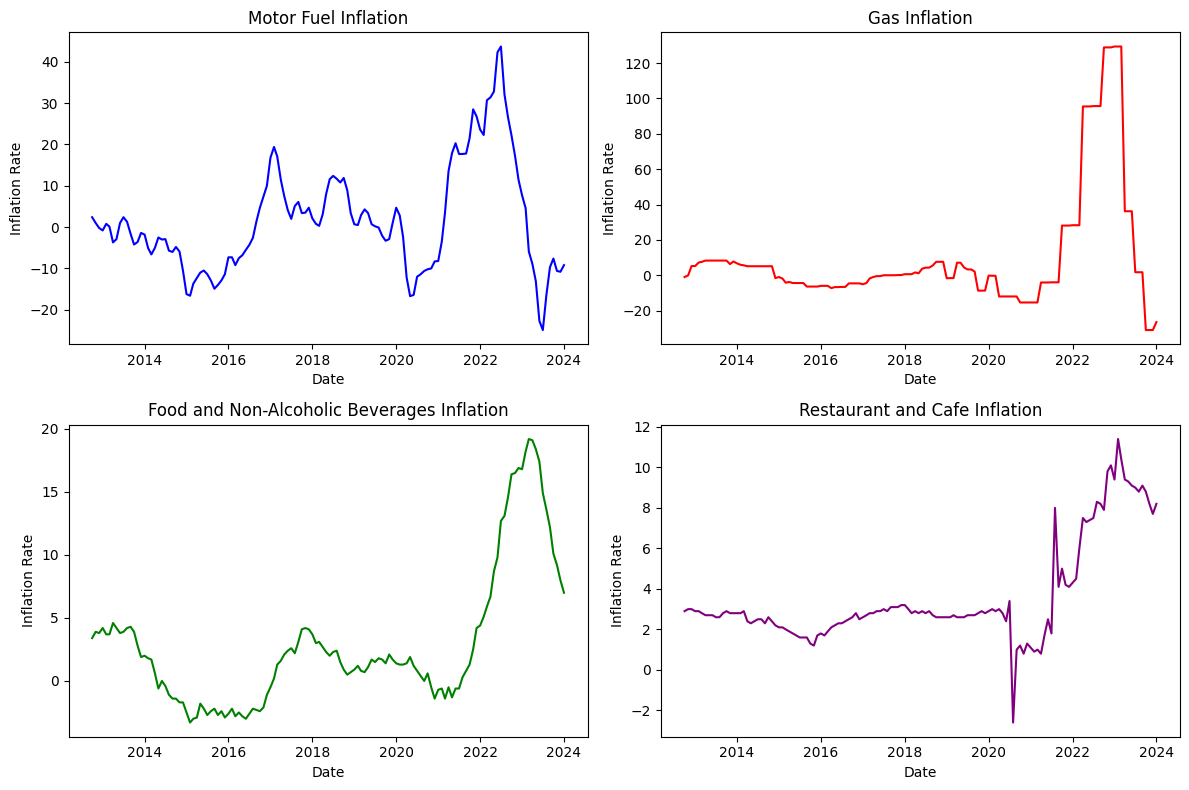

In [51]:
# Import libraries
import matplotlib.pyplot as plt

# Plot each dataset to visualize inflation trends
plt.figure(figsize=(12, 8))

# Motor Fuel Inflation
plt.subplot(2, 2, 1)
plt.plot(Motor_fuel_inflation.index, Motor_fuel_inflation['Motor fuels'], color='blue')
plt.title('Motor Fuel Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')

# Gas Inflation
plt.subplot(2, 2, 2)
plt.plot(gas_inflation.index, gas_inflation['Gas'], color='red')
plt.title('Gas Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')

# Food Inflation
plt.subplot(2, 2, 3)
plt.plot(food_inflation.index, food_inflation['Food and non-alcoholic beverages'], color='green')
plt.title('Food and Non-Alcoholic Beverages Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')

# Restaurant and Cafe Inflation
plt.subplot(2, 2, 4)
plt.plot(restaurant_cafe_inflation.index, restaurant_cafe_inflation['Restaurants and cafés'], color='purple')
plt.title('Restaurant and Cafe Inflation')
plt.xlabel('Date')
plt.ylabel('Inflation Rate')

plt.tight_layout()
plt.show()


# SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

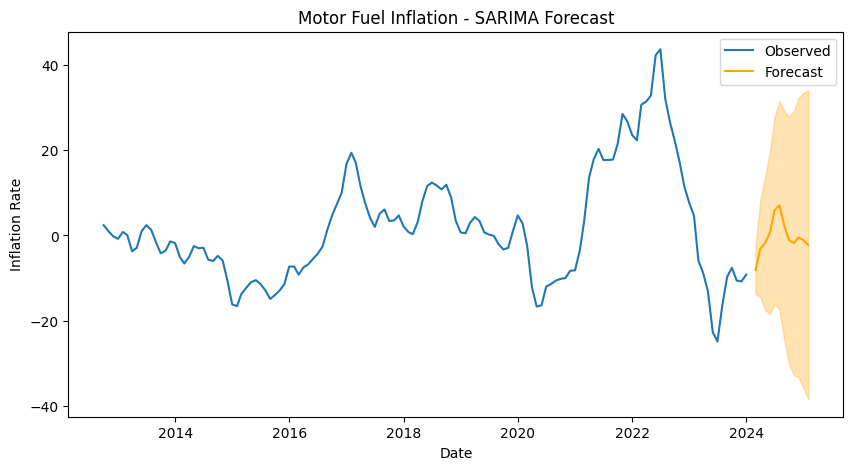

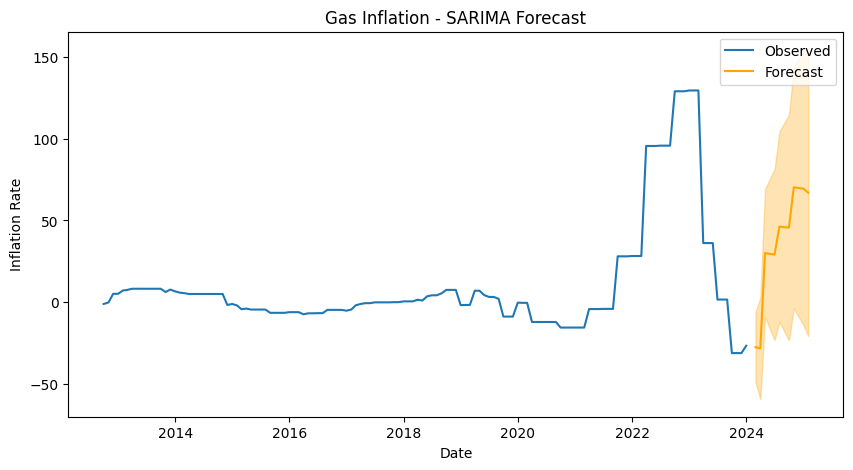

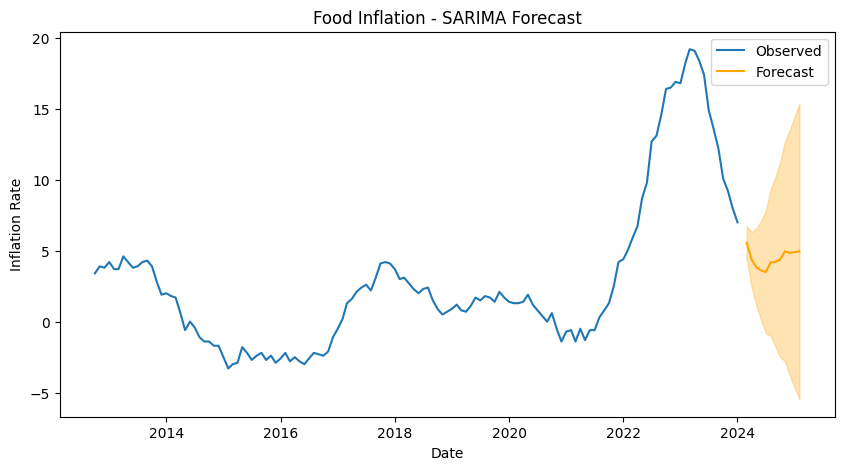

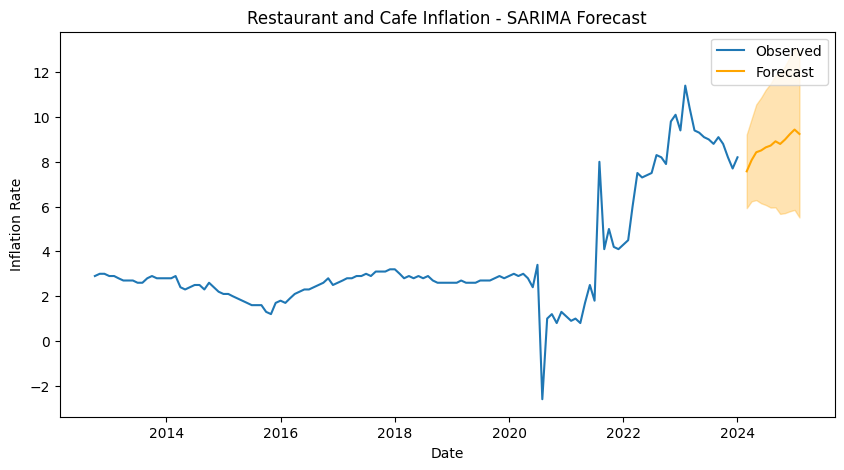

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function to fit SARIMA model and forecast
def sarima_forecast(series, steps=12):
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_model = model.fit(disp=False)
    forecast = sarima_model.get_forecast(steps=steps)
    forecast_ci = forecast.conf_int()
    return forecast, forecast_ci

# Forecast for each dataset
motor_fuel_forecast, motor_fuel_ci = sarima_forecast(Motor_fuel_inflation['Motor fuels'])
gas_forecast, gas_ci = sarima_forecast(gas_inflation['Gas'])
food_forecast, food_ci = sarima_forecast(food_inflation['Food and non-alcoholic beverages'])
restaurant_cafe_forecast, restaurant_cafe_ci = sarima_forecast(restaurant_cafe_inflation['Restaurants and cafés'])

# Plot SARIMA forecasts
def plot_sarima_forecast(series, forecast, ci, title):
    plt.figure(figsize=(10, 5))
    plt.plot(series, label='Observed')
    forecast_index = pd.date_range(series.index[-1], periods=len(forecast.predicted_mean) + 1, freq='M')[1:]
    plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='orange')
    plt.fill_between(forecast_index, ci.iloc[:, 0], ci.iloc[:, 1], color='orange', alpha=0.3)
    plt.title(f'{title} - SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Inflation Rate')
    plt.legend()
    plt.show()

# Plot each SARIMA forecast
plot_sarima_forecast(Motor_fuel_inflation['Motor fuels'], motor_fuel_forecast, motor_fuel_ci, 'Motor Fuel Inflation')
plot_sarima_forecast(gas_inflation['Gas'], gas_forecast, gas_ci, 'Gas Inflation')
plot_sarima_forecast(food_inflation['Food and non-alcoholic beverages'], food_forecast, food_ci, 'Food Inflation')
plot_sarima_forecast(restaurant_cafe_inflation['Restaurants and cafés'], restaurant_cafe_forecast, restaurant_cafe_ci, 'Restaurant and Cafe Inflation')
